In [140]:
import os
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

## Exercitiul 1

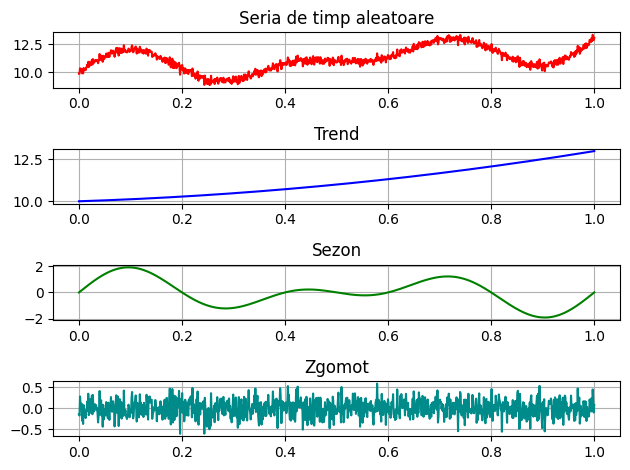

In [141]:
def trend(t: np.ndarray, a: int = 2, b: int = 1, c: int = 10) -> np.ndarray:
    return a * t ** 2 + b * t + c

def sezon(f1: int, f2: int, t: np.ndarray) -> np.ndarray:
    return np.sin(2 * np.pi * f1 * t) + np.sin(2 * np.pi * f2 * t)

def zgomot(scale: float, t: np.ndarray) -> np.ndarray:
    return np.random.normal(0, scale, len(t))

N = 1000
t = np.linspace(0, 1, N)

TREND = trend(t)
SEZON = sezon(3, 2, t)
ZGOMOT = zgomot(0.2, t)
time_series = TREND + SEZON + ZGOMOT

signals = [time_series, TREND, SEZON, ZGOMOT]
titles = [
    "Seria de timp aleatoare",
    "Trend",
    "Sezon",
    "Zgomot"
]
colors = ['red', 'blue', 'green', 'darkcyan']

fig, axs = plt.subplots(4, 1)
for i, signal in enumerate(signals):
    axs[i].plot(t, signal, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].grid()
    
plt.tight_layout()

if not os.path.exists('exercitiul1'):
    os.mkdir('exercitiul1')

plt.savefig(os.path.join('exercitiul1', f"exercitiul1.png"))
plt.savefig(os.path.join('exercitiul1', f"exercitiul1.pdf"))

plt.show()

## Exercitiul 2

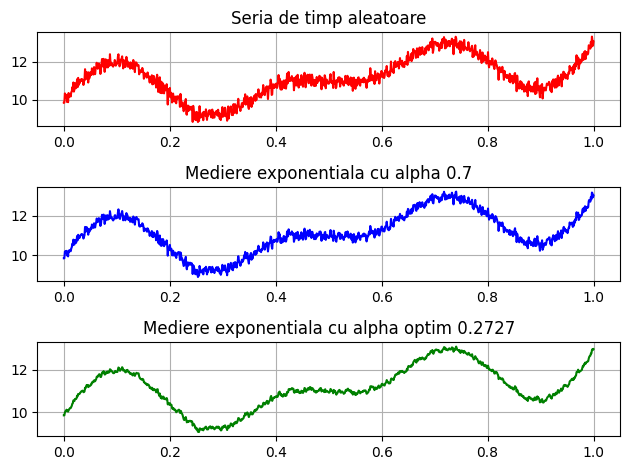

In [142]:
def exponential_smoothing(time_series: np.ndarray, alpha: float) -> np.ndarray:
    result = [time_series[0]]

    for n in range(1, len(time_series)):
        result.append(alpha * time_series[n] + (1 - alpha) * result[n - 1])

    return np.array(result)

initial_alpha = 0.7
optimal_alpha = None
min_error = np.inf
predictions = []

for alpha in np.linspace(0, 1, 100):
    predictions = exponential_smoothing(time_series[:-1], alpha)
    
    mse = mean_squared_error(time_series[1:], predictions)
    if mse < min_error:
        optimal_alpha, min_error = alpha, mse
        
signals = [
    time_series,
    exponential_smoothing(time_series, initial_alpha),
    exponential_smoothing(time_series, optimal_alpha)
]
titles = [
    "Seria de timp aleatoare",
    f"Mediere exponentiala cu alpha {initial_alpha}",
    f"Mediere exponentiala cu alpha optim {optimal_alpha:.4f}",
]
colors = ['red', 'blue', 'green']

fig, axs = plt.subplots(3, 1)
for i, signal in enumerate(signals):
    axs[i].plot(t, signal, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].grid()

plt.tight_layout()

if not os.path.exists('exercitiul2'):
    os.mkdir('exercitiul2')

plt.savefig(os.path.join('exercitiul2', f"exercitiul2.png"))
plt.savefig(os.path.join('exercitiul2', f"exercitiul2.pdf"))

plt.show()

## Exercitiul 3

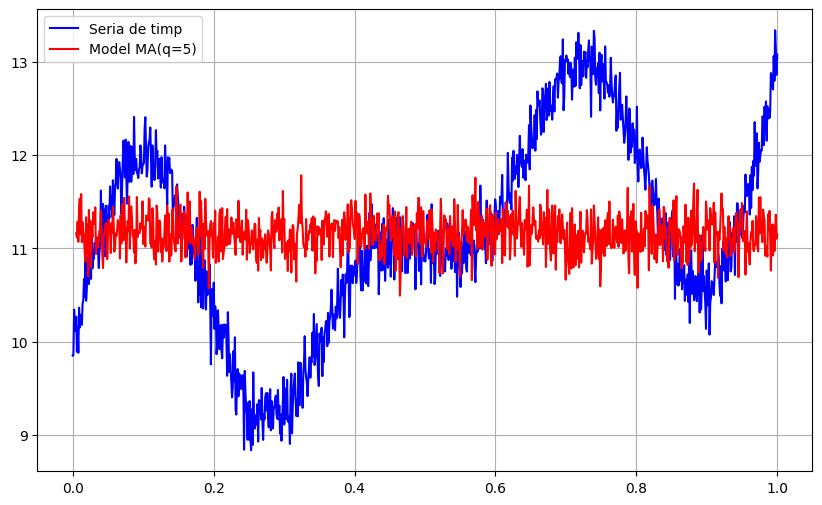

In [151]:
def generate_ma_model(series: np.ndarray, theta_values: np.ndarray) -> np.ndarray:
    q = len(theta_values)
    ma_model = np.zeros(len(series))
    errors = np.random.normal(0, 0.2, len(time_series))

    for i in range(q, len(series)):
        ma_model[i] += np.sum(theta_values * errors[i-q:i]) + errors[i] + np.mean(series)

    return ma_model

theta_values = np.array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005])
ma_model = generate_ma_model(time_series, theta_values)

plt.figure(figsize=(10, 6))
plt.plot(t, time_series, label="Seria de timp", color='blue')
plt.plot(t[len(theta_values):], ma_model[len(theta_values):], label=f"Model MA(q=5)", color='red')
plt.legend()
plt.grid()

if not os.path.exists('exercitiul3'):
    os.mkdir('exercitiul3')

plt.savefig(os.path.join('exercitiul3', f"exercitiul3.png"))
plt.savefig(os.path.join('exercitiul3', f"exercitiul3.pdf"))

plt.show()

## Exercitiul 4

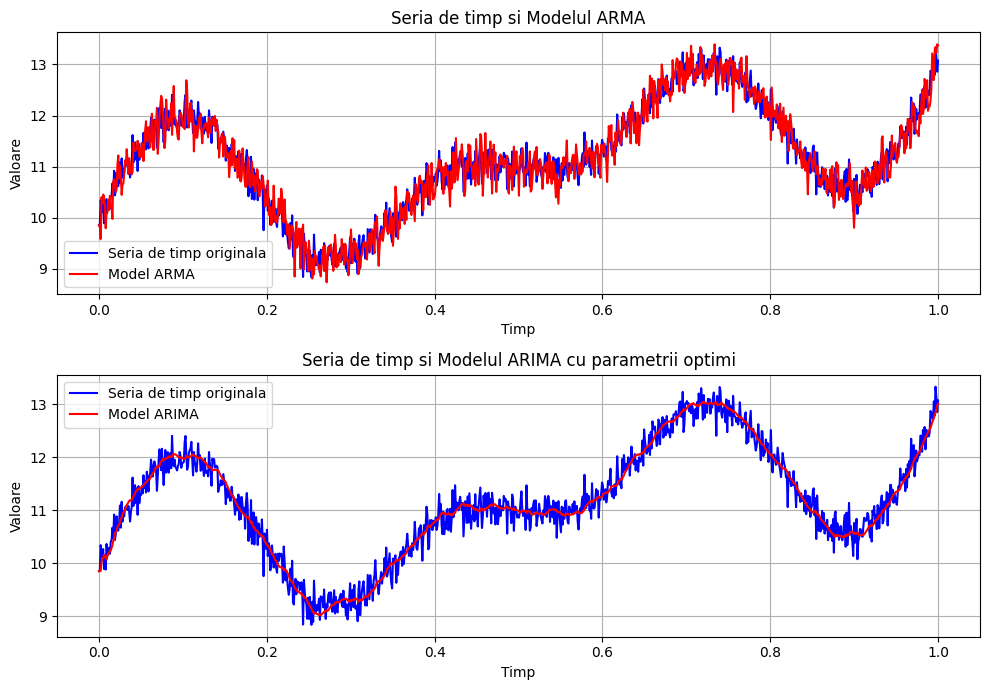

Parametrii optimi: p=1, q=2


In [144]:
def arma_model(time_series: np.ndarray, p: int, q: int, xi: np.ndarray, theta: np.ndarray) -> np.ndarray:
    y_pred = np.zeros_like(time_series, dtype=float)
    errors = np.random.normal(0, 0.2, len(time_series))

    for t in range(max(p, q), len(time_series)):
        ar_component = np.sum(xi * time_series[t-p:t])
        ma_component = np.sum(theta * errors[t-q:t])
        y_pred[t] = ar_component + ma_component + errors[t]

    return y_pred

p = 2
q = 1
xi = np.array([0.4, 0.6]) 
theta = np.array([0.2])
arma_pred = arma_model(time_series, p, q, xi, theta)
arma_pred[:p] = time_series[:p]

model = pm.auto_arima(time_series, suppress_warnings=True, seasonal=False, stepwise=True, max_p=20, max_q=20)
p, d, q = model.order

arima_model = ARIMA(time_series, order=(p, d, q))
arima_result = arima_model.fit().fittedvalues
arima_result[:p] = time_series[:p]

fig, axs = plt.subplots(2, 1, figsize=(10, 7))

axs[0].plot(t, time_series, label="Seria de timp originala", color='blue')
axs[0].plot(t, arma_pred, label="Model ARMA", color='red')
axs[0].set_title("Seria de timp si Modelul ARMA")
axs[0].set_xlabel("Timp")
axs[0].set_ylabel("Valoare")
axs[0].legend()
axs[0].grid()

axs[1].plot(t, time_series, label="Seria de timp originala", color='blue')
axs[1].plot(t, arima_result, label="Model ARIMA", color='red')
axs[1].set_title("Seria de timp si Modelul ARIMA cu parametrii optimi")
axs[1].set_xlabel("Timp")
axs[1].set_ylabel("Valoare")
axs[1].legend()
axs[1].grid()

plt.tight_layout()

if not os.path.exists('exercitiul4'):
    os.mkdir('exercitiul4')

plt.savefig(os.path.join('exercitiul4', f"exercitiul4.png"))
plt.savefig(os.path.join('exercitiul4', f"exercitiul4.pdf"))

plt.show()

print(f"Parametrii optimi: p={p}, q={q}")